This notebook builds a classifier for comfortable climate based on relative humidity and temperature.  The classifiers we will use are decision trees and k-nearest neighbors. 

We import our libraries below.

In [ ]:
import random
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import neighbors
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import math
import graphviz 

sns.set_palette('colorblind')

Next, we define two functions:

- `aboveline` computes a slope and intersept based on variables `x1` and `x2`.  It then returns `True` if `x3[1]` is above the line defined by this slope and intercept.

- `comfort` which calculates if the temperature, relative humidity combination is comfortable



In [ ]:
def aboveline(x1,x2,x3):
#   x[1] = m * x[0] + b
#   need to pick m and b so x1 and x2 are hit
    m = (x2[1] - x1[1])/(x2[0] - x1[0])
#    b = x1[1] * (x2[0] - x1[0]) - (x2[1] - x1[1]) * x1[0]
    b = x1[1] - m * x1[0]
#    slope2 = (x3[1] - x1[1])/(x3[0]-x1[0])
    return(x3[1] > m * x3[0] + b)

def comfort(temp,rh):
#    rh,  temp
#    86.5,67.1
#    29.3,69.0
# from https://www.azosensors.com/article.aspx?ArticleID=487
    return(
         aboveline([86.5,67.1],[29.3,69.0],[rh,temp]) and
         aboveline([29.3,69.0],[23.0,76.0],[rh,temp]) and
         not aboveline([23.0,76.0],[58.3,74.3],[rh,temp]) and
         not aboveline([58.3,74.3],[86.5,67.1],[rh,temp]))

With these two functions, we will create 500 random temperature relative humidity combinatons.

We now will train a decision tree classifier, print the number of correctly classified datapoints.

We will also plot the data we have generated below

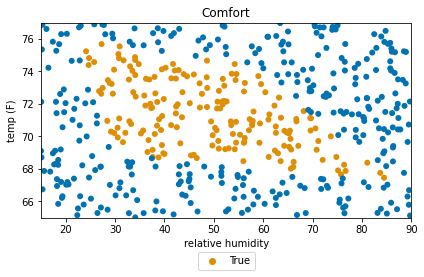

In [ ]:
# training a decision-tree classifier
N = 10500
all_dat = pd.DataFrame(columns=['temp (F)', 'relative humidity'], index=range(N))
all_dat['temp (F)'] = np.random.uniform(65, 77, N)
all_dat['relative humidity'] = np.random.uniform(15,90, N)
all_dat['labs'] = pd.Series([comfort(all_dat['temp (F)'].loc[i], all_dat['relative humidity'].loc[i]) for i in range(N)])

dat, test_dat, labs, test_labs = train_test_split(all_dat[['temp (F)', 'relative humidity']],
                                                  all_dat['labs'], test_size=10000)

# Plot
ax = sns.scatterplot(x='relative humidity', y='temp (F)', hue='labs', data=pd.concat([dat, labs], axis=1), linewidth=0, marker='o')
h,l = ax.get_legend_handles_labels()
plt.ylim(65,77)
plt.xlim(15,90)
plt.legend(h[1:], l[1:], bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=2)
plt.title('Comfort')
plt.tight_layout()

We train our decision tree classifier with 7 decision rules and print the training accuracy below.

In [ ]:
clf = tree.DecisionTreeClassifier(max_leaf_nodes=7)

clf = clf.fit(dat, labs)
correct = sum(clf.predict(dat) == labs)
print(correct/len(dat))

0.932


Below is the test set accuracy.

In [ ]:
test_correct = sum(clf.predict(test_dat) == test_labs)
print(test_correct/len(test_dat))

0.8982


In the following code block we:

- generate a test dataset of 10,000 examples
- plot the results with the following colors:
  - yellow: true positives
  - blue: true negatives
  - green: false postives
  - orange: false negatives

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


(15.0, 90.0)

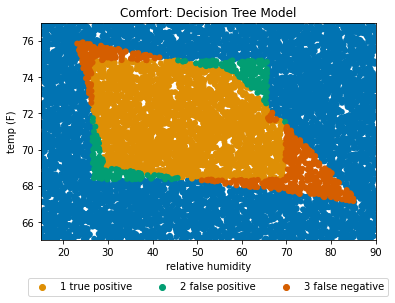

In [ ]:
# Create test data

def get_predictions(predictions, labels):
  prediction_info = pd.Series(index=labels.index, name='prediction')
  prediction_info.loc[np.logical_and(~predictions, ~labels)] = '0 true negative'
  prediction_info.loc[np.logical_and(predictions, labels)] = '1 true positive'
  prediction_info.loc[np.logical_and(predictions, ~labels)]= '2 false positive'
  prediction_info.loc[np.logical_and(~predictions, labels)] = '3 false negative'
  return prediction_info



ax = sns.scatterplot(y='temp (F)', x='relative humidity', hue='prediction',
                     data=pd.concat([test_dat,
                                     get_predictions(pd.Series(clf.predict(test_dat), index=test_labs.index),
                                     test_labs)], axis=1).sort_values(by='prediction',
                                                                      ascending=True), linewidth=0, marker='o')
h,l = ax.get_legend_handles_labels()
plt.legend(h[1:], l[1:], bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=4)
plt.title('Comfort: Decision Tree Model')
plt.ylim(65,77)
plt.xlim(15,90)

Next, we will visualize the decision rules learned by the decision tree we trained

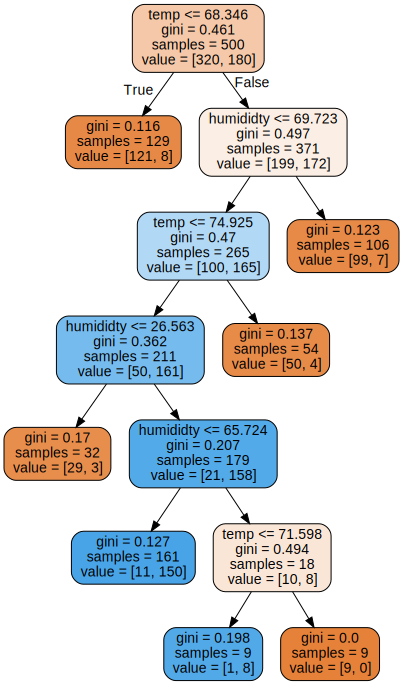

In [ ]:
dot_data = tree.export_graphviz(clf, feature_names=["temp","humididty"],
                      filled=True, rounded=True) 
graph = graphviz.Source(dot_data)	
graph	

Now we'll train a k-nearest neighbors classifier where k=1

We will then caluclate the percent of examples that were predicted correctly within the training set

In [ ]:
clf = neighbors.KNeighborsClassifier(n_neighbors=1)
clf = clf.fit(dat, labs)
correct = sum(clf.predict(dat) == labs)/len(dat.index)
print(correct)

1.0


We also calculate the accuracy on the test set

In [ ]:
# Create test data

correct = sum(clf.predict(test_dat) == test_labs)/len(test_dat.index)
print(correct)

0.937


We also will plot the:

- true positives
- false positives
- true negatives
- false negatives

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


(15.0, 90.0)

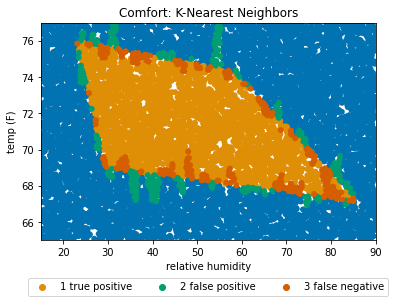

In [ ]:
ax = sns.scatterplot(y='temp (F)', x='relative humidity', hue='prediction',
                     data=pd.concat([test_dat,
                                     get_predictions(pd.Series(clf.predict(test_dat), index=test_labs.index),
                                     test_labs)], axis=1).sort_values(by='prediction',
                                                                      ascending=True), linewidth=0, marker='o')
h,l = ax.get_legend_handles_labels()
plt.legend(h[1:], l[1:], bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=4)
plt.title('Comfort: K-Nearest Neighbors')
plt.ylim(65,77)
plt.xlim(15,90)

How does the k-nearest neighbors change when we scale the training data.  We'll scale the training data by 6 and see how the accuracy changes on the training set.

In [ ]:
scale=6
scaleddat = pd.concat([scale*dat['temp (F)'],
                                     dat['relative humidity']], axis=1)

clf = neighbors.KNeighborsClassifier(n_neighbors=1)
clf = clf.fit(scaleddat, labs)
correct = sum(clf.predict(scaleddat) == labs)/len(dat.index)
print(correct)

1.0


We also see the accuracy on the test set given the scaling.

In [ ]:
scaledtestdat = pd.concat([scale*test_dat['temp (F)'],
                                     test_dat['relative humidity']], axis=1)

correct = sum(clf.predict(scaledtestdat) == test_labs)/len(test_dat.index)
print(correct)

0.9632


Below is our final plot of the:

- true positives
- fales positives
- true negatives
- false negatives

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


(15.0, 90.0)

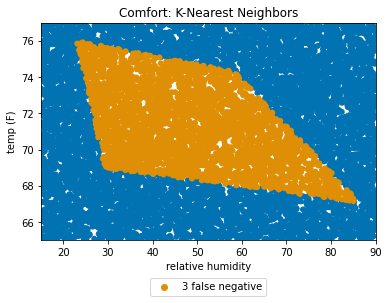

In [ ]:
ax = sns.scatterplot(y='temp (F)', x='relative humidity', hue='prediction',
                     data=pd.concat([test_dat,
                                     get_predictions(pd.Series(clf.predict(scale*test_dat), index=test_labs.index),
                                     test_labs)], axis=1).sort_values(by='prediction',
                                                                      ascending=True), linewidth=0, marker='o')
h,l = ax.get_legend_handles_labels()
plt.legend(h[1:], l[1:], bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=4)
plt.title('Comfort: K-Nearest Neighbors')
plt.ylim(65,77)
plt.xlim(15,90)